# 라이브러리 import

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import (Activation, BatchNormalization, Concatenate, Dense,
                                     Embedding, Flatten, Input, Multiply, Reshape)
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam

In [ ]:
img_rows = 28
img_cols = 28
channels = 1

# 입력 이미지 차원
img_shape = (img_rows, img_cols, channels)

# 생성자 입력으로 사용될 잡음 벡터 크기
z_dim = 100

# 데이터셋에 있는 클래스 개수
num_classes = 10

# 생성자

In [ ]:
def build_generator(z_dim):

    model = Sequential()

    # 완전 연결 층을 사용해 입력을 7×7×256 텐서로 변환합니다.
    model.add(Dense(256 * 7 * 7, input_dim=z_dim))
    model.add(Reshape((7, 7, 256)))

    # 7×7×256에서 14×14×128 텐서로 바꾸는 전치 합성곱 층
    model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))

    # 배치 정규화
    model.add(BatchNormalization())

    # LeakyReLU 활성화
    model.add(LeakyReLU(alpha=0.01))

    # 14×14×128에서 14×14×64 텐서로 바꾸는 전치 합성곱 층
    model.add(Conv2DTranspose(64, kernel_size=3, strides=1, padding='same'))

    # 배치 정규화
    model.add(BatchNormalization())

    # LeakyReLU 활성화
    model.add(LeakyReLU(alpha=0.01))

    # 14×14×64에서 28×28×1 텐서로 바꾸는 전치 합성곱 층
    model.add(Conv2DTranspose(1, kernel_size=3, strides=2, padding='same'))

    # tanh 활성화 함수
    model.add(Activation('tanh'))

    return model

# CGAN 생성자
레이블 y(0 ~ 9까지의 정수)를 받아 케라스 Embedding 층으로 z_dim 크기(랜덤한 노이즈 벡터의 길이)의 밀집 벡터로 변환한다.
- 레이블 y를 노이즈 벡터인 z와 동일한 크기의 벡터로 임베딩한다.</br>

케라스 Multiply 층으로 레이블 임베딩과 노이즈 벡터 z를 합친다.
- 임베딩 된 레이블과 z의 원소끼리 곱한다.
- 이 층의 이름으로 알 수 있듯이 동일한 길이 두 개의 벡터를 각 원소에 곱하여 곱셈결과로 이루어진 하나의 벡터를 출력한다. 

In [ ]:
def build_cgan_generator(z_dim):

    # 랜덤 잡음 벡터 z
    z = Input(shape=(z_dim, ))

    # 조건 레이블: 정수 0-9까지 생성자가 만들 숫자
    label = Input(shape=(1, ), dtype='int32')

    # 레이블 임베딩: 
    # ----------------
    # 레이블을 z_dim 크기 밀집 벡터로 변환하고 
    # (batch_size, 1, z_dim) 크기 3D 텐서를 만듭니다.
    label_embedding = Embedding(num_classes, z_dim, input_length=1)(label)

    # 임베딩된 3D 텐서를 펼쳐서 (batch_size, z_dim) 크기 2D 텐서로 바꿉니다.
    label_embedding = Flatten()(label_embedding)

    # 벡터 z와 레이블 임베딩의 원소별 곱셈
    joined_representation = Multiply()([z, label_embedding])

    generator = build_generator(z_dim)

    # 주어진 레이블에 대한 이미지 생성
    conditioned_img = generator(joined_representation)

    return Model([z, label], conditioned_img)

# 판별자
1. 레이블을 펼친 이미지의 크기(28x28x1 = 784)의 벡터로 임베딩시킴.
2. 임베딩된 레이블을 입력 이미지와 동일한 크기(28x28x1)의 텐서로 바꿈
3. 크기를 바꾼 레이블과 이에 해당하는 이미지를 연결함
4. 모델 입력 차원을 새 입력 크기 28x28x2 에 맞게 변경함
5. 첫 번째 합성곱 층의 깊이를 32에서 64로 늘림 (-> 연결된 레이블 인베딩 때문에 인코딩할 정보가 많아서)
6. 출력층에는 시그모이드 함수를 사용함

In [ ]:
def build_discriminator(img_shape):

    model = Sequential()

    # 28×28×2에서 14×14×64 텐서로 바꾸는 합성곱 층
    model.add(
        Conv2D(64,
               kernel_size=3,
               strides=2,
               input_shape=(img_shape[0], img_shape[1], img_shape[2] + 1),
               padding='same'))

    # LeakyReLU 활성화 함수
    model.add(LeakyReLU(alpha=0.01))

    # 14×14×64에서 7×7×64 텐서로 바꾸는 합성곱 층
    model.add(
        Conv2D(64,
               kernel_size=3,
               strides=2,
               padding='same'))

    # LeakyReLU 활성화 함수
    model.add(LeakyReLU(alpha=0.01))

    # 7×7×64에서 3×3×128 텐서로 바꾸는 합성곱 층
    model.add(
        Conv2D(128,
               kernel_size=3,
               strides=2,
               padding='same'))

    # LeakyReLU 활성화 함수
    model.add(LeakyReLU(alpha=0.01))

    # 시그모이드 활성화 함수를 사용한 출력층
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

#CGAN 판별자

In [ ]:
def build_cgan_discriminator(img_shape):

    # 입력 이미지
    img = Input(shape=img_shape)

    # 입력 이미지의 레이블
    label = Input(shape=(1, ), dtype='int32')

    # 레이블 임베딩: 
    # ----------------
    # 레이블을 z_dim 크기의 밀집 벡터로 변환하고 
    # (batch_size, 1, 28×28×1) 크기의 3D 텐서를 만듭니다.
    label_embedding = Embedding(num_classes,
                                np.prod(img_shape),
                                input_length=1)(label)

    # 임베딩된 3D 텐서를 펼쳐서 (batch_size, 28×28×1) 크기의 2D 텐서를 만듭니다.
    label_embedding = Flatten()(label_embedding)

    # 레이블 임베딩 크기를 입력 이미지 차원과 동일하게 만듭니다.
    label_embedding = Reshape(img_shape)(label_embedding)

    # 이미지와 레이블 임베딩을 연결합니다.
    concatenated = Concatenate(axis=-1)([img, label_embedding])

    discriminator = build_discriminator(img_shape)

    # 이미지-레이블 쌍을 분류합니다.
    classification = discriminator(concatenated)

    return Model([img, label], classification)

# 모델 만들기

In [ ]:
def build_cgan(generator, discriminator):

    # 랜덤 잡음 벡터 z
    z = Input(shape=(z_dim, ))

    # 이미지 레이블
    label = Input(shape=(1, ))

    # 레이블에 맞는 이미지 생성하기
    img = generator([z, label])

    classification = discriminator([img, label])

    # 생성자 -> 판별자 연결 모델 
    # G([z, label]) = x* 
    # D(x*) = 분류
    model = Model([z, label], classification)

    return model

In [ ]:
# 판별자 만들고 컴파일하기
discriminator = build_cgan_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy',
                      optimizer=Adam(learning_rate=0.00001),
                      metrics=['accuracy'])

# 생성자 만들기
generator = build_cgan_generator(z_dim)

# 생성자를 훈련하는 동안 판별자 모델 파라미터를 고정하기
discriminator.trainable = False

# 생성자를 훈련하기 위해 고정된 판별자로 CGAN 모델 만들고 컴파일하기
cgan = build_cgan(generator, discriminator)
cgan.compile(loss='binary_crossentropy', optimizer=Adam())

# CGAN 훈련 알고리즘
1. Discriminator(판별자)를 훈련
- 진짜 샘플 레이블의 랜덤한 미니배치(x, y)를 받음
- 미니배치에 대한 D((x, y))를 계산하고 이진 분류 손실(binary_crossentropy)을 역전파 하여 세타(D)를 업데이트하고 손실을 최소화 함
- 랜덤 노이즈 벡터와 클래스 레이블의 미니배치 (z, y)를 받고 가짜 샘플의 미니배치 G(z, y) = x*|y 를 생성
- 미니배치에 대해 D(x*|y, y)를 계산하고 이진 분류 손실(binary_crossentropy)을 역전파 하여 세타(D)를 업데이트하고 손실을 최소화 함
2. Generator(식별자)를 훈련
- 랜덤 잡은 벡터와 클래스 레이블의 미니배치(z, y)를 받고 가짜 샘플의 미니배치 G(z, y) = x*|y를 생성
- 주어진 미니배치에 대한 D(x*|y, y)를 계산하고 이진 분류 손실(binary_crossentropy)을 역전파하여 세타(G)를 업데이트하고 손실을 최대화 함

In [ ]:
accuracies = []
losses = []

def train(iterations, batch_size, sample_interval):

  # MNIST 데이터셋을 로드함
  (X_train, y_train), (_, _) = mnist.load_data()

  # [0, 255] 사이의 흑백 픽셀 값을 [-1, 1]로 스케일 변환함
  X_train = X_train / 127.5 - 1.
  X_train = np.expand_dims(X_train, axis=3)

  # 진짜 이미지의 레이블: 모두 1
  real = np.ones((batch_size, 1))
  # 가짜 이미지의 레이블: 모두 0
  fake = np.zeros((batch_size, 1))

  for iteration in range(iterations):
    # -------------------------
    #  판별자를 훈련합니다.
    # -------------------------

    # 진짜 이미지와 레이블로 이루어진 랜덤한 배치를 얻음
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    imgs, labels = X_train[idx], y_train[idx]

    # 가짜 이미지 배치를 생성
    z = np.random.normal(0, 1, (batch_size, z_dim))
    gen_imgs = generator.predict([z, labels])

    # 판별자를 훈련함
    d_loss_real = discriminator.train_on_batch([imgs, labels], real)
    d_loss_fake = discriminator.train_on_batch([gen_imgs, labels], fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    # ---------------------
    #  생성자를 훈련합니다.
    # ---------------------
    
    # 노이즈 벡터의 배치를 생성
    z = np.random.normal(0, 1, (batch_size, z_dim))
    
    # 랜덤한 레이블의 배치를 얻음
    labels = np.random.randint(0, num_classes, batch_size).reshape(-1, 1)

    # 생성자를 훈련
    g_loss = cgan.train_on_batch([z, labels], real)

    if (iteration + 1) % sample_interval == 0:
      # 훈련 과정을 출력
      print(f'{iteration + 1} [D loss: {d_loss[0]}, acc: {100 * d_loss[1]:.2f}, G loss: {g_loss}]')
      
      # 훈련이 끝난 후 그래프를 그리기 위해 손실과 정확도를 저장
      losses.append((d_loss[0], g_loss))
      accuracies.append(100 * d_loss[1])

      # 생성한 이미지 샘플을 출력함
      sample_images()







In [ ]:
def sample_images(image_grid_rows=2, image_grid_columns= 5):
  # 랜덤한 노이즈를 샘플링함
  z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

  # 0 ~ 9 사이의 이미지 레이블을 만듦
  labels = np.arange(0, 10).reshape(-1, 1)

  # 랜덤한 노이즈에서 이미지를 생성함
  gen_imgs = generator.predict([z, labels])

  # 이미지 픽셀 값을 [0, 1] 사이로 스케일을 변환함
  gen_imgs = 0.5 * gen_imgs + 0.5

  # 이미지 그리드를 설정함
  fig, axs = plt.subplots(image_grid_rows,
                          image_grid_columns,
                          figsize=(10, 4),
                          sharey = True,
                          sharex = True)
  
  cnt = 0

  for i in range(image_grid_rows):
    for j in range(image_grid_columns):
      # 이미지 그리드를 출력함
      axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
      axs[i, j].axis('off')
      axs[i, j].set_title(f"Digit: {labels[cnt]}")
      cnt += 1

# 모델을 훈련하고 훈련 과정 확인하기

1000 [D loss: 0.7473289966583252, acc: 46.88, G loss: 0.5614408850669861]
2000 [D loss: 0.68190798163414, acc: 93.75, G loss: 0.6937441825866699]
3000 [D loss: 0.6914839148521423, acc: 45.31, G loss: 0.6594856381416321]
4000 [D loss: 0.6609233617782593, acc: 76.56, G loss: 0.7587778568267822]
5000 [D loss: 0.6889272034168243, acc: 42.19, G loss: 0.6451791524887085]
6000 [D loss: 0.6409988105297089, acc: 92.19, G loss: 0.7755954265594482]
7000 [D loss: 0.7098565101623535, acc: 39.06, G loss: 0.6071983575820923]
8000 [D loss: 0.6973993182182312, acc: 59.38, G loss: 0.6972101330757141]
9000 [D loss: 0.6496104300022125, acc: 95.31, G loss: 0.7234406471252441]
10000 [D loss: 0.7110960483551025, acc: 39.06, G loss: 0.6291735172271729]
11000 [D loss: 0.6921458542346954, acc: 42.19, G loss: 0.6292853355407715]
12000 [D loss: 0.6578819155693054, acc: 87.50, G loss: 0.7219684720039368]
13000 [D loss: 0.7160148024559021, acc: 29.69, G loss: 0.623157799243927]
14000 [D loss: 0.6932964324951172, ac

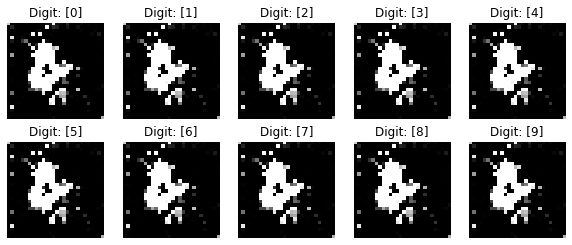

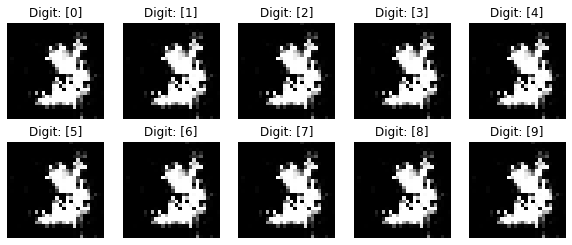

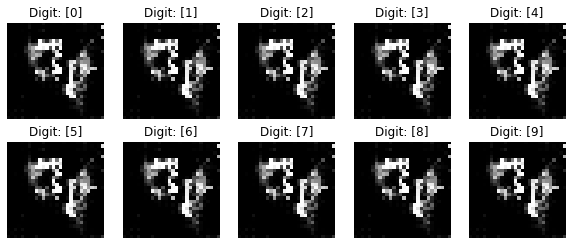

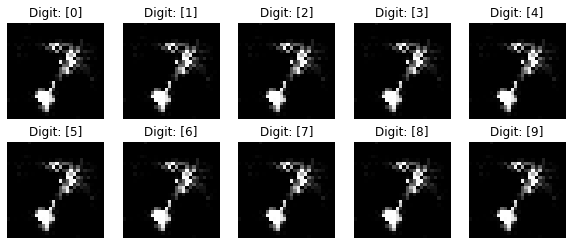

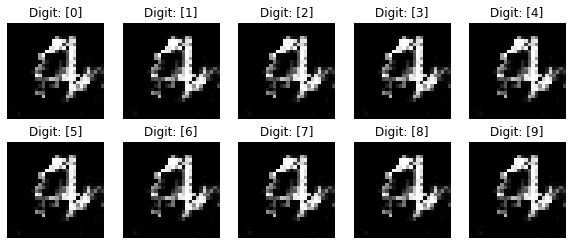

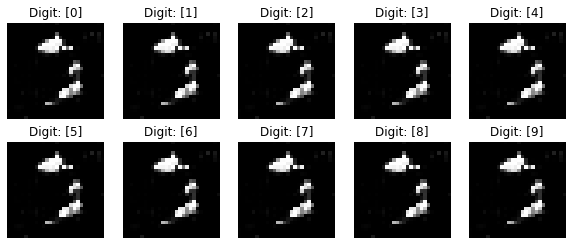

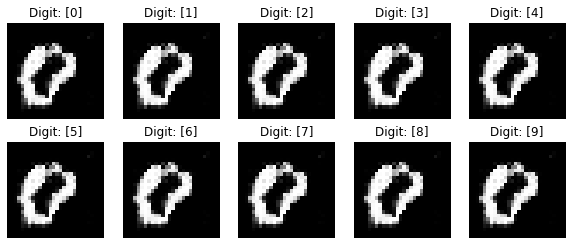

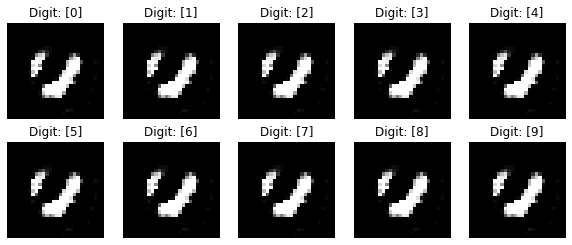

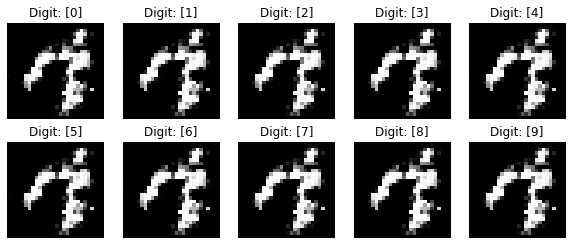

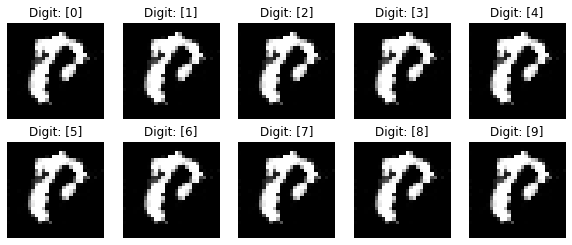

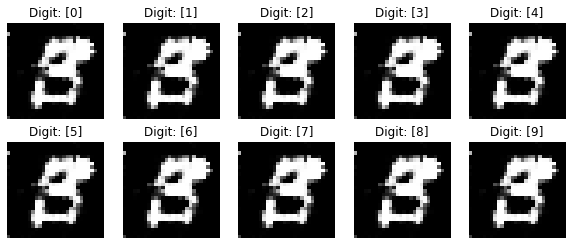

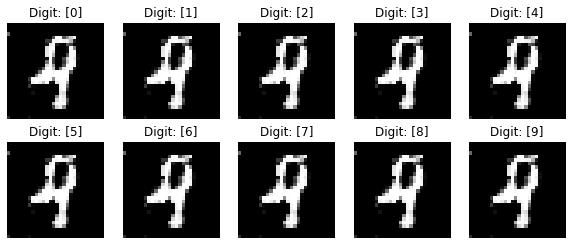

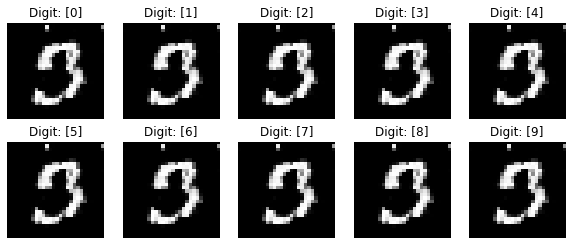

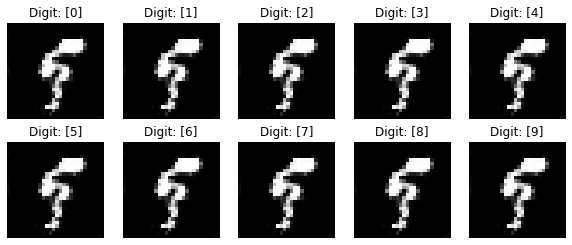

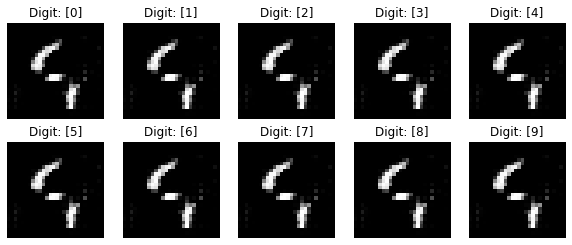

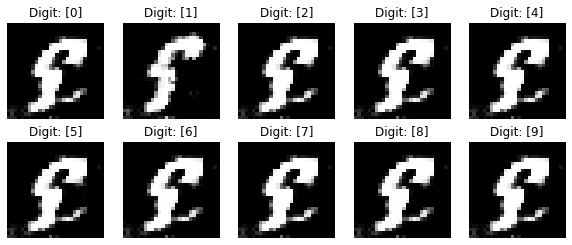

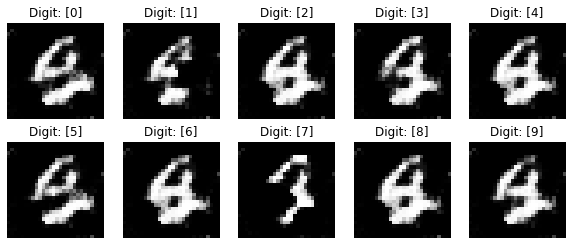

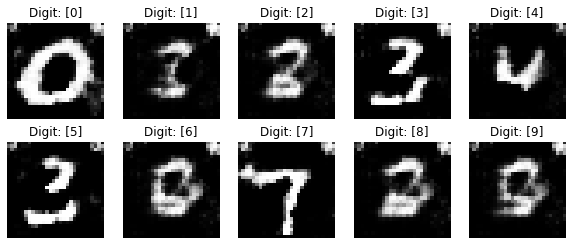

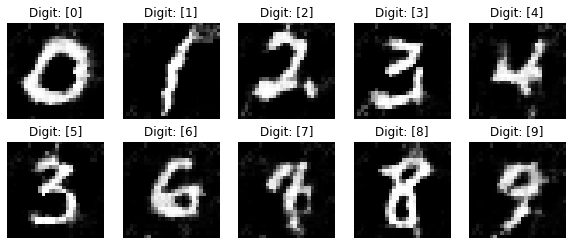

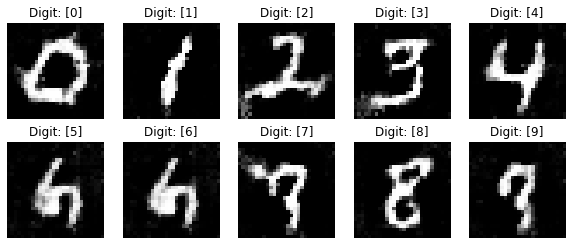

In [ ]:
# 하이퍼 파라미터 설정하기
iterations = 20000
batch_size = 32
sample_interval = 1000

# 지정된 반복 횟수 동안 CGAN을 훈련함
train(iterations, batch_size, sample_interval)

훈련된 CGAN 모델의 출력

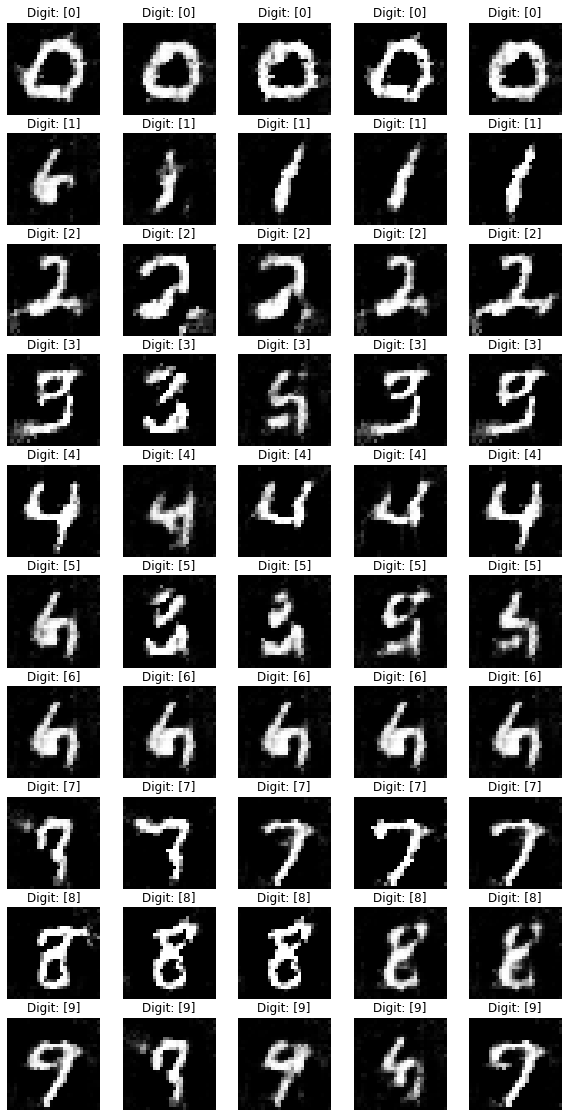

In [ ]:
# 그리드 차원을 설정
image_grid_rows = 10
image_grid_columns = 5

# 랜덤한 노이즈를 샘플링
z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

# 생성할 이미지 레이블을 5개씩 준비함
labels_to_generate = np.array([[i for j in range(5)] for i in range(10)])
labels_to_generate = labels_to_generate.flatten().reshape(-1, 1)

# 랜덤한 잡음에서 이미지를 생성
gen_imgs = generator.predict([z, labels_to_generate])

# 이미지 픽셀 값을 [0, 1] 사이로 스케일을 변환함
gen_imgs = 0.5 * gen_imgs + 0.5

# 이미지 그리드를 설정함
fig, axs = plt.subplots(image_grid_rows,
                        image_grid_columns,
                        figsize=(10, 20),
                        sharey = True,
                        sharex = True)

cnt = 0

for i in range(image_grid_rows):
  for j in range(image_grid_columns):
    # 이미지 그리드를 출력함
    axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
    axs[i, j].axis('off')
    axs[i, j].set_title(f"Digit: {labels_to_generate[cnt]}") # NEW!!
    cnt += 1